<a href="https://colab.research.google.com/github/LarrySnyder/RLforInventory/blob/main/notebooks/1_NV_as_MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Newsvendor Problem as a Multi-Armed Bandit (MAB)

This notebook contains code for an MAB implementation of the newsvendor problem.

---
> **Note:** This file is read-only. To work with it, you first need to save a copy to your Google Drive:
> 
> 1. Go to the File menu. (The File menu inside the notebook, right below the filename—not the File menu in your browser, at the top of your screen.)
> 2. Choose Save a copy in Drive. (Log in to your Google account, if necessary.) Feel free to move it to a different folder in your Drive, if you want.
> 3. Colab should open up a new browser tab with your copy of the notebook. 
> 4. Close the original read-only notebook in your browser.
---

---
> This notebook is part of the *Summer Bootcamp at Kellogg: RL in Operations* workshop at Northwestern University, August 2022. The notebooks are for Day 4, taught by Prof. Larry Snyder, Lehigh University.
---

# [INTRO MAB/NV STUFF HERE]

### Preliminary Python Stuff

In [1]:
# Import the packages we will need.
import numpy as np
#import copy
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
#from tqdm.notebook import tqdm
#from tabulate import tabulate

We have to install the `stockpyl` package so we can use it below. (It doesn't come pre-installed on Colab like `numpy`, etc. do.) You should only need to do this once per notebook.

If you get a message like

```
WARNING: The following packages were previously imported in this runtime:
  [sphinxcontrib]
You must restart the runtime in order to use newly installed versions.
```

you can ignore it.


In [ ]:
!pip install stockpyl

In [13]:
from stockpyl import newsvendor

### Bandit Class

First, we'll define a `Bandit` class that implements a multi-armed bandit (MAB). 

The class is very simple. It has two attributes:

* `k`: the number of arms
* `mean`: a list of mean rewards, one per bandit
* `sd`: a list of standard deviations of rewards, one per bandit

And the class has three methods:

* `__init__()` initializes the class
* `optimal_action()` returns the index of the optimal action; this is basically just a shortcut to the optimal solution
* `pull()` takes an action and returns a randomly generated reward for that action

At its default values, the bandit has $k=5$ arms whose rewards have mean $[1, \ldots, 5]$ (respectively) and standard deviation 1.

In [3]:
class Bandit(object):

    def __init__(self, k: int = 5, mean: list = list(range(5)), sd: list = [1]*5):
        """Initialize the attributes."""
        self.k = k
        self.mean = mean
        self.sd = sd

    def optimal_action(self):
        """Return the action with the largest mean."""
        return np.argmax(self.mean)

    def pull(self, action: int):
        """Get a random variate from a normal distribution with the mean and SD
        corresponding to the action."""
        return norm.rvs(loc=self.mean[action], scale=self.sd[action])


Let's give it a spin 🎰. 

(Sorry—dad joke.) 

In [4]:
bandit = Bandit(k=3, mean=[5, 3, 1], sd=[1, 1, 0.5])
for _ in range(10):
    a = np.random.randint(3)
    r = bandit.pull(a)
    print(f"Pulled arm {a}, got reward {r}")

Pulled arm 1, got reward 2.6505163634537108
Pulled arm 2, got reward 1.146996844526327
Pulled arm 0, got reward 4.470522700587773
Pulled arm 2, got reward 1.5056028339566427
Pulled arm 0, got reward 6.192360347129539
Pulled arm 0, got reward 5.544880126515056
Pulled arm 2, got reward 1.4695600171647771
Pulled arm 0, got reward 6.17350656578218
Pulled arm 0, got reward 3.753395532819381
Pulled arm 1, got reward 3.215182831297481


### $\epsilon$-Greedy Class

Next we'll define an `EpsilonGreedyAgent` class that implements the $\epsilon$-greedy algorithm for generic MABs. The algorithm implementation is based on the discussions in Sutton and Barto (2nd edition, 2018).

In order to use the class, you need to provide it with an instance of the `Bandit` class defined above.

Feel free to explore the code if you want, but all that's required is for you to execute the cell.

In [5]:
class EpsilonGreedyAgent(object):

    def __init__(self, bandit: Bandit, epsilon: float = 0.1):
        # Initialize the attributes.
        self.bandit = bandit
        self.epsilon = epsilon

    def epsilon_greedy(self, num_time_steps: int = 1000, initial_Q: list = None):
        # Initialize Q-value estimates (or use `initial_Q` if provided).
        Q = initial_Q or [0] * self.bandit.k
        # Initialize action counts.
        N = [0] * self.bandit.k

        # Initialize evaluation info.
        
        # Main loop.
        for t in range(num_time_steps):

            # Choose action.
            if np.random.rand() < 1 - self.epsilon:
                A = np.argmax(Q)
            else:
                A = np.random.randint(self.bandit.k)

            # Get reward.
            R = self.bandit.pull(A)

            # Update stats.
            N[A] += 1
            Q[A] += (1 / N[A]) * (R - Q[A])

        # Return Q estimates as well as best guess for optimal action.
        return Q, np.argmax(Q)

Let's try it.

In [6]:
agent = EpsilonGreedyAgent(bandit)
Q, A = agent.epsilon_greedy()
print(f"Best guess for optimal action is {A}")
print(f"Estimates of action values:")
for a in range(bandit.k):
    print(f"  {a}: {Q[a]}")

Best guess for optimal action is 0
Estimates of action values:
  0: 4.922213190810981
  1: 2.993602234912368
  2: 0.9172141877282236


### The Newsvendor Bandit

Now it's your turn. Your goal is to build a class called `NewsvendorBandit`. I started you off by building the structure of the class. (It's similar to the `Bandit` class declared earlier.) You need to fill in some details.

A few things to note:

* The `NewsvendorBandit` class takes a parameter `k`, like the `Bandit` class, that indicates the number of "arms". The arms will be indexed $a=0,\ldots,k-1$, and arm $a$ corresponds to using an order quantity of $a$.
* The class takes three parameters specifying the newsvendor problem instance: 

    * `h` and `p` are the holding and stockout costs
    * `mu` is the mean of the Poisson demand distribution
    
* "Pulling" an arm should return the **negative of the cost of one newsvendor period,** based on a randomly generated demand, rather than returning a random variate from a particular distribution.

---
**Note:** In the code below, the portions that you need to complete are marked with

```python
# #################
# TODO:
```

In place of the missing code is a line that says 

```python
	raise NotImplementedError
```

This is a way of telling Python to raise an exception (error) because there's something missing here. You should **delete (or comment out) this line** after you write your code.

---

In [7]:
class NewsvendorBandit(object):

    def __init__(self, k: int = 10, h: float = 1, p: float = 10, mu: int = 5):
        """Initialize the attributes."""
        self.k = k

        # #################
        # TODO: store the attributes h, p, and mu in the object, too.
        raise NotImplementedError

    def optimal_action(self):
        """Return the action with the smallest expected cost."""
        # #################
        # TODO: Set `action` to the action that minimizes the expected cost.
        # Hint: use stockpyl's newsvendor_poisson() function. 
        # See https://stockpyl.readthedocs.io/en/latest/api/seio/newsvendor.html#stockpyl.newsvendor.newsvendor_poisson
        raise NotImplementedError

        return action

    def pull(self, action: int):
        """Return a random newsvendor cost for the given action."""

        # Generate a Poisson(mu) random variate.
        d = poisson.rvs(self.mu)

        # #################
        # TODO: Calculate the cost for the chosen action and the random demand.
        # Set `reward` to the negative of this cost.
        raise NotImplementedError

        # Get a random variate from a normal distribution with the mean and SD
        # corresponding to the action.
        return reward

In [14]:
## SOLUTION ##
class NewsvendorBandit(object):

    def __init__(self, k: int = 10, h: float = 1, p: float = 10, mu: int = 5):
        """Initialize the attributes."""
        self.k = k

        # Store the attributes h, p, and mu in the object, too.
        self.h = h
        self.p = p
        self.mu = mu

    def optimal_action(self):
        """Return the action with the smallest expected cost."""
        # Set `action` to the action that minimizes the expected cost,
        # using stockpyl's newsvendor_poisson() function. 
        action, _ = newsvendor.newsvendor_poisson(self.h, self.p, self.mu)

        return action

    def pull(self, action: int):
        """Return a random newsvendor cost for the given action."""

        # Generate a Poisson(mu) random variate.
        d = poisson.rvs(self.mu)

        # Calculate the cost for the chosen action and the random demand.
        # Set `reward` to the negative of this cost.
        cost = self.h * max(action - d, 0) + self.p * max(d - action, 0)
        reward = -cost

        # Get a random variate from a normal distribution with the mean and SD
        # corresponding to the action.
        return reward

Let's try out your `NewsvendorBandit` class on a newsvendor instance with:

* $h=0.5$
* $p=15$
* $\mu=4$

We'll use 12 arms.

In [40]:
# Build the bandit.
num_arms = 12
bandit = NewsvendorBandit(k=num_arms, h=0.5, p=15, mu=4)

In [41]:
# Pull lever 5 a few times.
a = 5
for _ in range(10):
    r = bandit.pull(a)
    print(f"Pulled arm {a}, got reward {r}")

Pulled arm 5, got reward -1.0
Pulled arm 5, got reward -1.0
Pulled arm 5, got reward -0.0
Pulled arm 5, got reward -0.5
Pulled arm 5, got reward -1.0
Pulled arm 5, got reward -2.5
Pulled arm 5, got reward -0.0
Pulled arm 5, got reward -15.0
Pulled arm 5, got reward -0.5
Pulled arm 5, got reward -30.0


In [42]:
# Pull it a lot of times and get the average reward.
avg_reward = 0
a = 5
num_pulls = 10000
for _ in range(num_pulls):
    r = bandit.pull(a)
    avg_reward += r / num_pulls
print(f"Pulled arm {a} {num_pulls} times, got average reward {avg_reward}")

Pulled arm 5 10000 times, got average reward -7.126349999999884


In [43]:
# What is the *exact* optimal action, according to the bandit?
opt_action = bandit.optimal_action()
print(f"Optimal action is {opt_action}")

Optimal action is 8.0


Let's validate this by calculating the expected cost of using an order quantity of 5 (`stockpyl` calls this `base_stock_level`) for the given newsvendor instance.

In [44]:
_, exp_cost = newsvendor.newsvendor_poisson(
    bandit.h,
    bandit.p,
    bandit.mu,
    base_stock_level=a
)
print(f"Exact expected cost for order quantity 5 is {exp_cost}")

Exact expected cost for order quantity 5 is 6.859715013704245


And let's get the *optimal* order quantity using `stockpyl`.

In [45]:
opt_Q, opt_exp_cost = newsvendor.newsvendor_poisson(
    bandit.h,
    bandit.k,
    bandit.mu
)
print(f"Optimal order quantity is {opt_Q}, with expected cost {opt_exp_cost}")

Optimal order quantity is 8.0, with expected cost 2.4203373408439486


---
**Note:** Before proceeding, you should make sure that the results from your bandit are similar to those returned by `stockpyl`.

---

### Training the $\epsilon$-Greedy Agent for the Newsvendor MAB

Now let's train the $\epsilon$-greedy agent on the newsvendor MAB. The `EpsilonGreedyAgent` class does not need any modifications—we built it to be very generic—so all you need to do is pass your newsvendor bandit to it.

In [46]:
# #################
# TODO: Train the epsilon-greedy agent on your `NewsvendorBandit` object.
# Print the agent's buess guess for the optimal action, as well as its
# estimates of the action values. (Use the analogous cell above as a template.)
raise NotImplementedError

NotImplementedError: ignored

In [54]:
## SOLUTION
agent = EpsilonGreedyAgent(bandit)
Q, A = agent.epsilon_greedy(num_time_steps=1000)
print(f"Best guess for optimal action is {A}")
print(f"Estimates of action values:")
for a in range(bandit.k):
    print(f"  {a}: {Q[a]}")

Best guess for optimal action is 8
Estimates of action values:
  0: -60.0
  1: -50.0
  2: -27.583333333333336
  3: -7.5
  4: -15.392857142857142
  5: -7.6
  6: -3.3636363636363638
  7: -3.9351851851851847
  8: -2.33434835566382
  9: -2.4285714285714284
  10: -2.8181818181818183
  11: -3.1875


## Validating the Results

Let's compare your trained agent's action-value estimates (or really, their negatives) with the true expected costs of those actions as calculated by `stockpyl`. 

(The code below assumes that you have stored the agent's estimates of the action values in a variable called `Q` in the previous cell.)

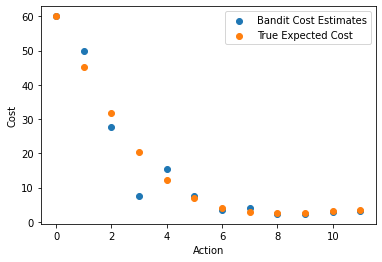

In [55]:
action_list = list(range(bandit.k))

bandit_cost = [-Q[a] for a in action_list]
exp_cost = [newsvendor.newsvendor_poisson(
    bandit.h, 
    bandit.p, 
    bandit.mu, 
    base_stock_level=a
)[1] for a in action_list]

plt.scatter(action_list, bandit_cost, label='Bandit Cost Estimates')
plt.scatter(action_list, exp_cost, label='True Expected Cost')
plt.legend()
plt.xlabel('Action')
plt.ylabel('Cost');

How good a job did your bandit and $\epsilon$-greedy agent do of estimating the expected cost function for the newsvendor problem?

(If you're not happy with the results, you can try increasing the `num_time_steps` parameter passed to the `epsilon_greedy()` method.)